In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb
import joblib


In [2]:
df = pd.read_csv('../data/22_subway_line.csv')

In [3]:
df.shape

(1128094, 95)

In [4]:
df.drop(['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호',
         'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
         'k-사용검사일-사용승인일', 'k-관리비부과면적', 'k-전용면적별세대현황(60이하)', 'k-전용면적별세대현황(60~85이하)',
         'k-85~135이하', 'k-135초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태',
         '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일'], axis=1, inplace=True)

In [5]:
# 추가로 제거가 필요한 feature 제거
df.drop(['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-관리방식', 'k-건설사(시공사)', 'k-시행사', 'k-연면적', 'k-주거전용면적',
         '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '시군구 번지', '좌표X,좌표Y', 'index', '역사_ID', '역사명', '위도', '경도',
         '가장 가까운 버스 정류장 index', '가장 가까운 버스 정류장 노드 ID', '가장 가까운 버스 정류소번호', '가장 가까운 버스 정류소명',
         '가장 가까운 버스 정류소 타입', '가장 가까운 버스 정류장 X좌표', '가장 가까운 버스 정류장 Y좌표', '동', 
         '구'], axis=1, inplace=True)

In [6]:
df.shape

(1128094, 35)

In [7]:
df['계약월'] = df['계약년월'].astype(str).str[4:].astype(int)

df.drop(['계약년월', '계약일'], axis=1, inplace=True)
df

,전용면적,층,건축년도,좌표X,좌표Y,target,is_test,가장 가까운 거리,호선,인근 지하철 역 개수,...,공시지가 평균,매수우위지수,건물나이,30년이상50년이하,구매력지수,거래활발지수,매매가격 지수 증감률,매매 대비 전세가격 비율,아파트 카테고리,지하철 카테고리
0,79.97,3,1987,127.05721,37.476763,124000.0,0,1127.738351,분당선,2.0,...,6.858562e+06,88.4,30,1,48.262095,17.693929,1.243615,70.059000,기타,분당선
1,79.97,4,1987,127.05721,37.476763,123500.0,0,1127.738351,분당선,2.0,...,6.858562e+06,88.4,30,1,48.262095,17.693929,1.243615,70.059000,기타,분당선
2,54.98,5,1987,127.05721,37.476763,91500.0,0,1127.738351,분당선,2.0,...,6.858562e+06,88.4,30,1,48.262095,17.693929,1.243615,70.059000,기타,분당선
3,79.97,4,1987,127.05721,37.476763,130000.0,0,1127.738351,분당선,2.0,...,7.322618e+06,118.0,31,1,46.647899,27.764117,2.459291,69.322000,기타,분당선
4,79.97,2,1987,127.05721,37.476763,117000.0,0,1127.738351,분당선,2.0,...,7.322618e+06,118.0,31,1,46.647899,27.764117,2.459291,69.322000,기타,분당선
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,84.65,13,2014,127.10672,37.618870,NaN,1,732.482898,경춘선,4.0,...,2.963517e+06,38.0,9,0,45.212818,12.462049,-0.641286,50.938744,기타,기타
1128090,84.62,12,2014,127.10672,37.618870,NaN,1,732.482898,경춘선,4.0,...,2.963517e+06,38.0,9,0,45.212818,12.462049,-0.641286,50.938744,기타,기타
1128091,101.65,12,2014,127.10672,37.618870,NaN,1,732.482898,경춘선,4.0,...,2.963517e+06,46.0,9,0,45.056635,13.703570,-0.607676,50.991003,기타,기타
1128092,84.94,18,2014,127.10672,37.618870,NaN,1,732.482898,경춘선,4.0,...,2.963517e+06,41.4,9,0,44.744578,17.287617,-0.225827,51.082553,기타,기타


In [8]:
df['계약월_sin'] = np.sin(2 * np.pi * df['계약월'] / 12)

In [9]:
df.drop(['계약월'], axis=1, inplace=True)

In [10]:
def scailing(col, scaler_type):
    if scaler_type == 'min_max': scaler = MinMaxScaler()
    else : scaler = StandardScaler()

    return scaler.fit_transform(df[[col]])

cols = ['전용면적', '층', '건축년도', '좌표X', '좌표Y', '가장 가까운 거리',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', 'GDP',
       '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량',
       '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '구매력지수', '거래활발지수',
       '매매가격 지수 증감률', '매매 대비 전세가격 비율',
       '계약월_sin']

for col in cols:
    print(col)
    scaler_type = 'min_max'
    if col == '계약월_sin': scaler_type = 'standard'

    df[[col]] = scailing(col, scaler_type)

전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
계약월_sin


In [11]:
ohe = OneHotEncoder(sparse_output=False)
ohe_re = ohe.fit_transform(df[['호선']])

In [12]:
df = pd.concat([df, pd.DataFrame(ohe_re, columns=[col for col in ohe.categories_[0]])], axis=1)

In [13]:
df.drop(['호선'], axis=1, inplace=True)
df

,전용면적,층,건축년도,좌표X,좌표Y,target,is_test,가장 가까운 거리,인근 지하철 역 개수,가장 가까운 버스 정류장 거리,...,경춘선,공항철도1호선,과천선,분당선,신림선,신분당선,신분당선(연장2),우이신설선,일산선,중앙선
0,0.168839,0.095890,0.419355,0.678243,0.167126,124000.0,0,0.353721,0.086957,0.101599,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.168839,0.109589,0.419355,0.678243,0.167126,123500.0,0,0.353721,0.086957,0.101599,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.108520,0.123288,0.419355,0.678243,0.167126,91500.0,0,0.353721,0.086957,0.101599,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.168839,0.109589,0.419355,0.678243,0.167126,130000.0,0,0.353721,0.086957,0.101599,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.168839,0.082192,0.419355,0.678243,0.167126,117000.0,0,0.353721,0.086957,0.101599,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,0.180135,0.232877,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128090,0.180063,0.219178,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128091,0.221168,0.219178,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128092,0.180835,0.301370,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df.drop(['9호선(연장)', '경부선', '경의중앙선', '신분당선',
         '신림선', '신분당선(연장2)', '중앙선', '8호선',
         '우이신설선', '공항철도1호선', '경인선',
         '1호선','일산선', '과천선', '경춘선'], axis=1, inplace=True)

In [15]:
df['30년이상50년이하'] = df['30년이상50년이하'].astype('category')
df['아파트 카테고리'] = df['아파트 카테고리'].astype('category')
df['지하철 카테고리'] = df['지하철 카테고리'].astype('category')

In [16]:
df_dropped = df.drop([], axis=1)

In [17]:
train_df = df_dropped[df_dropped['is_test'] == 0]
test_df = df_dropped[df_dropped['is_test'] == 1]

In [18]:
print(train_df.shape)
print(test_df.shape)

(1118822, 41)
(9272, 41)


In [19]:
train_df.drop(['is_test'], axis=1, inplace=True)
test_df.drop(['is_test'], axis=1, inplace=True)

In [20]:
train_X = train_df.drop(['target'], axis=1)
train_y = train_df[['target']]

In [21]:
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, train_size=0.95, test_size=0.05, random_state=74)

print(train_X.shape, train_y.shape)
print(valid_X.shape, valid_y.shape)

(1062880, 39) (1062880, 1)
(55942, 39) (55942, 1)


In [22]:
import optuna
import lightgbm as lgb

In [34]:
def objective(trial):
    param = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_categorical('n_estimators', [10000, 25000, 50000, 75000, 100000]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        
    }

    model = lgb.LGBMRegressor(**param)
    
    model.fit(
        train_X, train_y,
        eval_set=[(train_X, train_y), (valid_X, valid_y)],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(stopping_rounds=60),
            lgb.log_evaluation(period=10, show_stdv=True)
        ]
    )

    preds = model.predict(valid_X, num_iteration=model.best_iteration_)
    rmse = mean_squared_error(valid_y, preds, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(f"Best trial: {study.best_trial.value}")
print(f"Best params: {study.best_trial.params}")

In [36]:
best_params = study.best_trial.params
best_model = lgb.LGBMRegressor(**best_params)

best_model.fit(
    train_X, train_y,
    eval_set=[(train_X, train_y), (valid_X, valid_y)],
    eval_metric='rmse',
    callbacks=[
            lgb.early_stopping(stopping_rounds=60),
            lgb.log_evaluation(period=10, show_stdv=True)
        ]
)

preds = best_model.predict(valid_X, num_iteration=best_model.best_iteration_)
rmse = mean_squared_error(valid_y, preds, squared=False)
print(f"Final RMSE: {rmse}")


[LightGBM] [Warning] feature_fraction is set=0.753530055111983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.753530055111983
[LightGBM] [Warning] lambda_l2 is set=1.283619100140314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.283619100140314
[LightGBM] [Warning] lambda_l1 is set=0.321104316998921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.321104316998921
[LightGBM] [Warning] bagging_fraction is set=0.9831152659210419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9831152659210419
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.753530055111983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.753530055111983
[LightGBM] [Warning] lambda_l2 is set=1.283619100140314, reg_lambda=0.0 will be ignored. Current v

In [39]:
print(best_params)

{'n_estimators': 50000, 'learning_rate': 0.018121450498089327, 'num_leaves': 133, 'feature_fraction': 0.753530055111983, 'bagging_fraction': 0.9831152659210419, 'bagging_freq': 1, 'min_child_samples': 18, 'min_child_weight': 6.936639163177618, 'lambda_l1': 0.321104316998921, 'lambda_l2': 1.283619100140314}


In [37]:
preds_df = pd.DataFrame(preds.astype(int), columns=["target"])
preds_df.to_csv('v22_1_tuned_output.csv', index=False)

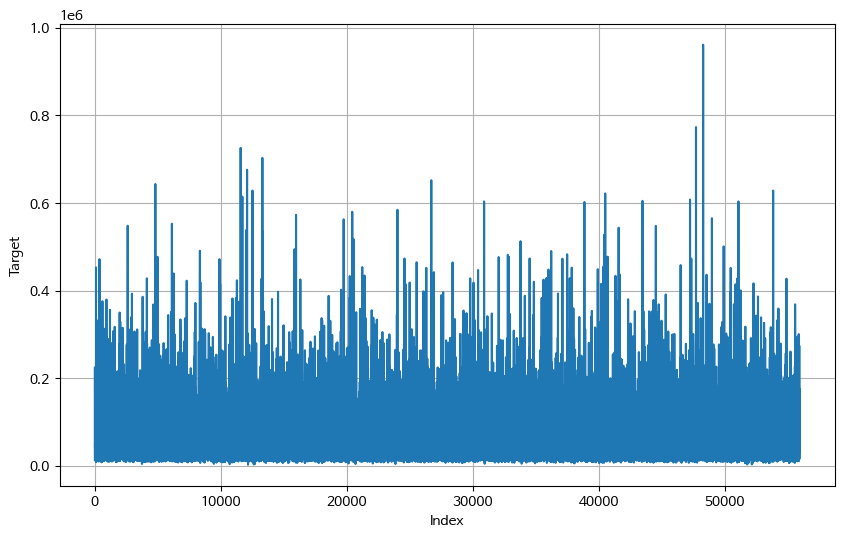

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.plot(preds_df['target'])
plt.xlabel('Index')
plt.ylabel('Target')
plt.grid(True)
plt.show()

In [47]:
from xgboost import XGBRegressor
import warnings;warnings.filterwarnings('ignore')

In [48]:
def objective(trial, X, y, name='xgb'):
    params = {
        'tree_method': 'gpu_hist',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'eta': trial.suggest_float('eta', 1e-5, 0.1),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.009, 0.01, 0.012, 0.016, 0.02]),
        'n_estimators': trial.suggest_categorical('n_estimators', [500, 1000, 2000, 3000, 4000, 5000]),
        'max_depth': trial.suggest_categorical('max_depth', [4, 5, 7, 9, 11, 13, 17]),
        'random_state': 42,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'random_state': 10
    }

    model = XGBRegressor(**params, enable_categorical=True)
    model.fit(train_X, train_y, eval_set=[(valid_X, valid_y)], verbose=False)

    predictions_train = np.clip(model.predict(train_X), 0, None)
    predictions_val = np.clip(model.predict(valid_X), 0, None)

    train_score = np.round(np.sqrt(metrics.mean_squared_error(train_y, predictions_train)), 5)
    test_score = np.round(np.sqrt(metrics.mean_squared_error(valid_y, predictions_val)), 5)

    print(f'TRAIN RMSE : {train_score} || TEST RMSE : {test_score}')

    return test_score

In [49]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_X, train_y), n_trials=50)

print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

best_params = study.best_trial.params
xgb = XGBRegressor(tree_method='gpu_hist', enable_categorical=True, random_state=2023, **best_params)
xgb.fit(train_X, train_y,
        eval_set=[(valid_X, valid_y)])

xgb_predictions = np.clip(xgb.predict(valid_X), 0, None)

rmse = np.sqrt(metrics.mean_squared_error(valid_y, xgb_predictions))
print('Final Model RMSE :', rmse)

[I 2024-07-19 10:31:37,764] A new study created in memory with name: no-name-91961d9f-cc05-41eb-a0cf-130a37aa45e6
[10:31:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:32:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:32:26,402] Trial 0 finished with value: 7369.30947 and parameters: {'lambda': 0.07864883775683404, 'alpha': 0.9878420193963082, 'eta': 0.09083242845024563, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 94}. Best is trial 0 with value: 7369.30947.


TRAIN RMSE : 6485.81002 || TEST RMSE : 7369.30947


[10:32:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:32:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:32:35,417] Trial 1 finished with value: 9640.06367 and parameters: {'lambda': 8.702967372485974, 'alpha': 0.0011814065793111122, 'eta': 0.0519795548480319, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 208}. Best is trial 0 with value: 7369.30947.


TRAIN RMSE : 9199.18063 || TEST RMSE : 9640.06367


[10:32:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:33:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:33:47,345] Trial 2 finished with value: 7078.07955 and parameters: {'lambda': 0.8562160165159075, 'alpha': 3.924326206561992, 'eta': 0.009683943976493328, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'n_estimators': 2000, 'max_depth': 13, 'min_child_weight': 141}. Best is trial 2 with value: 7078.07955.


TRAIN RMSE : 6026.37059 || TEST RMSE : 7078.07955


[10:33:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:34:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:34:06,441] Trial 3 finished with value: 10449.06044 and parameters: {'lambda': 0.006986596192188687, 'alpha': 0.031966828286983814, 'eta': 0.0803711720459638, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 4000, 'max_depth': 4, 'min_child_weight': 300}. Best is trial 2 with value: 7078.07955.


TRAIN RMSE : 10080.47873 || TEST RMSE : 10449.06044


[10:34:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:34:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:34:16,736] Trial 4 finished with value: 13483.04997 and parameters: {'lambda': 0.15950174796114988, 'alpha': 0.02057151105917985, 'eta': 0.07625627879597688, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'n_estimators': 2000, 'max_depth': 4, 'min_child_weight': 228}. Best is trial 2 with value: 7078.07955.


TRAIN RMSE : 13119.14234 || TEST RMSE : 13483.04997


[10:34:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:36:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:36:37,137] Trial 5 finished with value: 6554.8498 and parameters: {'lambda': 4.979466628669473, 'alpha': 9.664724105167354, 'eta': 0.032705244605884136, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 17, 'min_child_weight': 221}. Best is trial 5 with value: 6554.8498.


TRAIN RMSE : 4874.0307 || TEST RMSE : 6554.8498


[10:36:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:37:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:37:03,813] Trial 6 finished with value: 8717.7296 and parameters: {'lambda': 0.15907364743905514, 'alpha': 0.0039878303764728775, 'eta': 0.001832442024188519, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'n_estimators': 2000, 'max_depth': 9, 'min_child_weight': 292}. Best is trial 5 with value: 6554.8498.


TRAIN RMSE : 8087.91383 || TEST RMSE : 8717.7296


[10:37:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:37:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:37:50,847] Trial 7 finished with value: 7580.17087 and parameters: {'lambda': 5.7841835551549075, 'alpha': 0.013804882350403674, 'eta': 0.06529508906823096, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 4000, 'max_depth': 9, 'min_child_weight': 183}. Best is trial 5 with value: 6554.8498.


TRAIN RMSE : 6897.36165 || TEST RMSE : 7580.17087


[10:37:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:40:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:40:15,865] Trial 8 finished with value: 6282.08322 and parameters: {'lambda': 0.2519069270297235, 'alpha': 0.04363201368321006, 'eta': 0.07990908512445204, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 4000, 'max_depth': 17, 'min_child_weight': 178}. Best is trial 8 with value: 6282.08322.


TRAIN RMSE : 4605.79619 || TEST RMSE : 6282.08322


[10:40:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:41:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:41:46,694] Trial 9 finished with value: 6091.41871 and parameters: {'lambda': 0.9637894680281603, 'alpha': 0.019279075893489907, 'eta': 0.07202790521073277, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 42}. Best is trial 9 with value: 6091.41871.


TRAIN RMSE : 4403.62517 || TEST RMSE : 6091.41871


[10:41:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:43:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:43:27,534] Trial 10 finished with value: 5944.4522 and parameters: {'lambda': 0.0014463368645424913, 'alpha': 0.5103202826707391, 'eta': 0.09947540556595225, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 13}. Best is trial 10 with value: 5944.4522.


TRAIN RMSE : 3701.04495 || TEST RMSE : 5944.4522


[10:43:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:45:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:45:16,754] Trial 11 finished with value: 5916.90572 and parameters: {'lambda': 0.0011032825057708405, 'alpha': 0.3285169417957637, 'eta': 0.09357640755446091, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 9}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 3484.43178 || TEST RMSE : 5916.90572


[10:45:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:47:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:47:21,417] Trial 12 finished with value: 6071.78214 and parameters: {'lambda': 0.001076259831004607, 'alpha': 0.36660468577648087, 'eta': 0.09990625303790912, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 7}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 3878.0372 || TEST RMSE : 6071.78214


[10:47:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:47:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:47:38,837] Trial 13 finished with value: 9772.99833 and parameters: {'lambda': 0.0011135647943885055, 'alpha': 0.2045584245604978, 'eta': 0.0991068667124097, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 3000, 'max_depth': 5, 'min_child_weight': 53}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 9328.83969 || TEST RMSE : 9772.99833


[10:47:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:47:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:47:58,103] Trial 14 finished with value: 7544.09994 and parameters: {'lambda': 0.007086139652499281, 'alpha': 1.0276000767563767, 'eta': 0.054801950029832895, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 11, 'min_child_weight': 14}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 6481.01319 || TEST RMSE : 7544.09994


[10:47:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:49:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:49:17,220] Trial 15 finished with value: 6441.48995 and parameters: {'lambda': 0.004624940953917505, 'alpha': 0.12740576292339134, 'eta': 0.0325348030074275, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 88}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 4988.90233 || TEST RMSE : 6441.48995


[10:49:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:50:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:50:39,479] Trial 16 finished with value: 6571.27521 and parameters: {'lambda': 0.031166024867007168, 'alpha': 0.7554141951132053, 'eta': 0.09090318559507939, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 88}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 5298.84344 || TEST RMSE : 6571.27521


[10:50:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:51:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:51:04,834] Trial 17 finished with value: 8702.819 and parameters: {'lambda': 0.00238719236321774, 'alpha': 2.3242457919165433, 'eta': 0.06348101017761419, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 3000, 'max_depth': 7, 'min_child_weight': 49}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 8140.83753 || TEST RMSE : 8702.819


[10:51:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:52:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:52:18,472] Trial 18 finished with value: 6645.37455 and parameters: {'lambda': 0.027501002296533805, 'alpha': 0.07794197080853654, 'eta': 0.04033896157298293, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 119}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 5311.76682 || TEST RMSE : 6645.37455


[10:52:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:52:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:52:22,211] Trial 19 finished with value: 13751.55957 and parameters: {'lambda': 0.018506319088616077, 'alpha': 0.3517977536537869, 'eta': 0.091224368493662, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 5}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 13399.56114 || TEST RMSE : 13751.55957


[10:52:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:53:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:53:48,889] Trial 20 finished with value: 6115.29617 and parameters: {'lambda': 0.0027371862296545996, 'alpha': 2.658400452390458, 'eta': 0.0863691329031056, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 34}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 4306.62752 || TEST RMSE : 6115.29617


[10:53:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:56:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:56:03,950] Trial 21 finished with value: 6050.10407 and parameters: {'lambda': 0.00117337741966788, 'alpha': 0.3312603732631732, 'eta': 0.09972466434820094, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 5}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 3682.93612 || TEST RMSE : 6050.10407


[10:56:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:57:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:57:33,152] Trial 22 finished with value: 6553.42314 and parameters: {'lambda': 0.0018543439868907209, 'alpha': 0.4103577638740826, 'eta': 0.09845787282773993, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 56}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 5275.39288 || TEST RMSE : 6553.42314


[10:57:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[10:59:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 10:59:10,874] Trial 23 finished with value: 6281.83756 and parameters: {'lambda': 0.012282306577412494, 'alpha': 0.10902083591041102, 'eta': 0.08500208897174014, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 29}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 4758.96057 || TEST RMSE : 6281.83756


[10:59:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:00:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:00:38,738] Trial 24 finished with value: 6627.67184 and parameters: {'lambda': 0.0034784434016025536, 'alpha': 0.22620397548471066, 'eta': 0.07149989425651965, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 66}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 5405.17338 || TEST RMSE : 6627.67184


[11:00:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:02:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:02:15,709] Trial 25 finished with value: 6079.24664 and parameters: {'lambda': 0.0017653570343923945, 'alpha': 0.6964677780321089, 'eta': 0.0939927088724538, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 21}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 4250.75797 || TEST RMSE : 6079.24664


[11:02:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:02:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:02:19,465] Trial 26 finished with value: 16011.80681 and parameters: {'lambda': 0.0010522568666842278, 'alpha': 1.4340896420246838, 'eta': 0.08502447357837058, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 78}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 15669.0593 || TEST RMSE : 16011.80681


[11:02:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:02:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:02:28,788] Trial 27 finished with value: 9744.33634 and parameters: {'lambda': 0.006916923955737188, 'alpha': 0.0586953157729029, 'eta': 0.06314777661132501, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 112}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 9299.11562 || TEST RMSE : 9744.33634


[11:02:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:03:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:03:46,461] Trial 28 finished with value: 6045.48049 and parameters: {'lambda': 0.053961038171230116, 'alpha': 5.912054388255243, 'eta': 0.018914953466260875, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 3748.29167 || TEST RMSE : 6045.48049


[11:03:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:04:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:04:23,961] Trial 29 finished with value: 7006.09072 and parameters: {'lambda': 0.049828193954209114, 'alpha': 8.635433002892672, 'eta': 0.01767958322929357, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 3000, 'max_depth': 9, 'min_child_weight': 109}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 6123.59978 || TEST RMSE : 7006.09072


[11:04:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:05:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:05:08,573] Trial 30 finished with value: 6800.08453 and parameters: {'lambda': 0.7223737218497611, 'alpha': 5.455827559602009, 'eta': 0.016863425438580562, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 71}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 5741.58317 || TEST RMSE : 6800.08453


[11:05:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:06:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:06:12,876] Trial 31 finished with value: 6376.15103 and parameters: {'lambda': 0.004780542994419972, 'alpha': 1.5727629835226833, 'eta': 0.043523309655312675, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 5000, 'max_depth': 9, 'min_child_weight': 27}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 5094.36085 || TEST RMSE : 6376.15103


[11:06:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:07:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:07:30,926] Trial 32 finished with value: 6037.52093 and parameters: {'lambda': 0.012738691566441335, 'alpha': 0.5467420842306562, 'eta': 0.024528770617154916, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 3733.58079 || TEST RMSE : 6037.52093


[11:07:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:08:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:08:32,402] Trial 33 finished with value: 6252.16399 and parameters: {'lambda': 0.05177836196551664, 'alpha': 0.5278690705691591, 'eta': 0.023648140181508466, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 9, 'min_child_weight': 31}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 4843.6858 || TEST RMSE : 6252.16399


[11:08:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:08:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:08:49,444] Trial 34 finished with value: 7657.29265 and parameters: {'lambda': 0.016228945241692962, 'alpha': 0.16849951053939743, 'eta': 0.006302995742607266, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 5}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 6529.69198 || TEST RMSE : 7657.29265


[11:08:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:08:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:08:59,632] Trial 35 finished with value: 11636.65916 and parameters: {'lambda': 0.08097047990762053, 'alpha': 4.191823341322443, 'eta': 0.028960779718958142, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 2000, 'max_depth': 4, 'min_child_weight': 41}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 11331.4454 || TEST RMSE : 11636.65916


[11:09:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:10:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:10:46,652] Trial 36 finished with value: 6363.06228 and parameters: {'lambda': 0.01041877124456834, 'alpha': 1.479263906267784, 'eta': 0.016210394821716923, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 13, 'min_child_weight': 139}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 4901.98614 || TEST RMSE : 6363.06228


[11:10:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:11:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:11:33,486] Trial 37 finished with value: 7130.48834 and parameters: {'lambda': 0.25149846666415715, 'alpha': 0.0069400045193195575, 'eta': 0.04815566569642532, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 4000, 'max_depth': 9, 'min_child_weight': 261}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 6273.82417 || TEST RMSE : 7130.48834


[11:11:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:18:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:18:09,113] Trial 38 finished with value: 5963.91061 and parameters: {'lambda': 0.02975342050669048, 'alpha': 2.168729246395792, 'eta': 0.02437207112406512, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 5000, 'max_depth': 17, 'min_child_weight': 23}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 2830.28433 || TEST RMSE : 5963.91061


[11:18:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:22:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:22:42,462] Trial 39 finished with value: 6077.50589 and parameters: {'lambda': 0.02744030080556729, 'alpha': 0.9118676404326043, 'eta': 0.03801205446120137, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 2000, 'max_depth': 17, 'min_child_weight': 19}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 3432.32993 || TEST RMSE : 6077.50589


[11:22:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:26:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:26:45,773] Trial 40 finished with value: 6251.26679 and parameters: {'lambda': 0.0069812697138284755, 'alpha': 2.8694157405327148, 'eta': 0.009020787761503453, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 5000, 'max_depth': 17, 'min_child_weight': 57}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 3975.71209 || TEST RMSE : 6251.26679


[11:26:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:33:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:33:52,734] Trial 41 finished with value: 5958.69054 and parameters: {'lambda': 0.05203177917454961, 'alpha': 5.438321624258506, 'eta': 0.02433123099611705, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 5000, 'max_depth': 17, 'min_child_weight': 19}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 2671.91376 || TEST RMSE : 5958.69054


[11:33:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:40:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:40:41,073] Trial 42 finished with value: 5969.18227 and parameters: {'lambda': 0.1145808674287821, 'alpha': 2.118209834121395, 'eta': 0.024227538974919586, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 5000, 'max_depth': 17, 'min_child_weight': 21}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 2753.97222 || TEST RMSE : 5969.18227


[11:40:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:47:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:47:28,492] Trial 43 finished with value: 5960.02944 and parameters: {'lambda': 0.16282970678142963, 'alpha': 2.437345416731905, 'eta': 0.025904367905794097, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 5000, 'max_depth': 17, 'min_child_weight': 21}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 2754.43192 || TEST RMSE : 5960.02944


[11:47:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:52:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:52:20,228] Trial 44 finished with value: 6151.84939 and parameters: {'lambda': 0.4906915421702584, 'alpha': 3.9346441437419615, 'eta': 0.00017262123332355966, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'n_estimators': 4000, 'max_depth': 17, 'min_child_weight': 41}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 3641.78861 || TEST RMSE : 6151.84939


[11:52:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:56:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:56:15,362] Trial 45 finished with value: 6279.20229 and parameters: {'lambda': 1.7734113713791706, 'alpha': 7.266275339573319, 'eta': 0.01263465690704469, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 5000, 'max_depth': 17, 'min_child_weight': 69}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 4062.33676 || TEST RMSE : 6279.20229


[11:56:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:59:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 11:59:13,019] Trial 46 finished with value: 6644.11414 and parameters: {'lambda': 0.27515138595677785, 'alpha': 1.065071089043268, 'eta': 0.03343898664001227, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 5000, 'max_depth': 17, 'min_child_weight': 172}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 5082.79182 || TEST RMSE : 6644.11414


[11:59:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[12:01:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 12:01:22,441] Trial 47 finished with value: 6942.23979 and parameters: {'lambda': 2.3109311912355253, 'alpha': 3.774510322244924, 'eta': 0.028421074896437436, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 3000, 'max_depth': 17, 'min_child_weight': 201}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 5915.61931 || TEST RMSE : 6942.23979


[12:01:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[12:01:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 12:01:25,702] Trial 48 finished with value: 17453.47902 and parameters: {'lambda': 0.34263378302351827, 'alpha': 1.848937635841627, 'eta': 0.054648174124279456, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 4, 'min_child_weight': 46}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 17176.26152 || TEST RMSE : 17453.47902


[12:01:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[12:04:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[I 2024-07-19 12:04:56,320] Trial 49 finished with value: 5975.23267 and parameters: {'lambda': 0.1485071382031856, 'alpha': 0.2716966844471688, 'eta': 0.03570878800126095, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 2000, 'max_depth': 17, 'min_child_weight': 14}. Best is trial 11 with value: 5916.90572.


TRAIN RMSE : 2612.50058 || TEST RMSE : 5975.23267
Best trial: score 5916.90572, params {'lambda': 0.0011032825057708405, 'alpha': 0.3285169417957637, 'eta': 0.09357640755446091, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 9}
[0]	validation_0-rmse:46491.52456
[1]	validation_0-rmse:45851.17783
[2]	validation_0-rmse:45200.31597


[12:04:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



[3]	validation_0-rmse:44582.78626
[4]	validation_0-rmse:43975.38369
[5]	validation_0-rmse:43361.10824
[6]	validation_0-rmse:42848.93380
[7]	validation_0-rmse:42362.92015
[8]	validation_0-rmse:41774.72640
[9]	validation_0-rmse:41197.12861
[10]	validation_0-rmse:40626.15105
[11]	validation_0-rmse:40166.90131
[12]	validation_0-rmse:39614.45227
[13]	validation_0-rmse:39083.39838
[14]	validation_0-rmse:38658.59213
[15]	validation_0-rmse:38124.21739
[16]	validation_0-rmse:37615.59012
[17]	validation_0-rmse:37125.07437
[18]	validation_0-rmse:36634.42061
[19]	validation_0-rmse:36152.91333
[20]	validation_0-rmse:35667.46738
[21]	validation_0-rmse:35211.08353
[22]	validation_0-rmse:34752.96503
[23]	validation_0-rmse:34367.33845
[24]	validation_0-rmse:33907.27084
[25]	validation_0-rmse:33536.39927
[26]	validation_0-rmse:33091.20737
[27]	validation_0-rmse:32648.07576
[28]	validation_0-rmse:32220.51604
[29]	validation_0-rmse:31795.88184
[30]	validation_0-rmse:31460.62286
[31]	validation_0-rmse:3105

[12:06:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



In [50]:
params = {'lambda': 0.0011032825057708405, 'alpha': 0.3285169417957637, 'eta': 0.09357640755446091, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 5000, 'max_depth': 11, 'min_child_weight': 9}

In [53]:
test_df.drop(['target'], axis=1, inplace=True)

In [54]:
xgb = XGBRegressor(tree_method='gpu_hist', enable_categorical=True, random_state=2023, **params)
xgb.fit(train_X, train_y, 
        eval_set=[(valid_X, valid_y)])

xgb_predictions = xgb.predict(test_df)

[0]	validation_0-rmse:46491.52456
[1]	validation_0-rmse:45851.17783


[13:26:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



[2]	validation_0-rmse:45200.31597
[3]	validation_0-rmse:44582.78626
[4]	validation_0-rmse:43975.38369
[5]	validation_0-rmse:43361.10824
[6]	validation_0-rmse:42848.93380
[7]	validation_0-rmse:42362.92015
[8]	validation_0-rmse:41774.72640
[9]	validation_0-rmse:41197.12861
[10]	validation_0-rmse:40626.15105
[11]	validation_0-rmse:40166.90131
[12]	validation_0-rmse:39614.45227
[13]	validation_0-rmse:39083.39838
[14]	validation_0-rmse:38658.59213
[15]	validation_0-rmse:38124.21739
[16]	validation_0-rmse:37615.59012
[17]	validation_0-rmse:37125.07437
[18]	validation_0-rmse:36634.42061
[19]	validation_0-rmse:36152.91333
[20]	validation_0-rmse:35667.46738
[21]	validation_0-rmse:35211.08353
[22]	validation_0-rmse:34752.96503
[23]	validation_0-rmse:34367.33845
[24]	validation_0-rmse:33907.27084
[25]	validation_0-rmse:33536.39927
[26]	validation_0-rmse:33091.20737
[27]	validation_0-rmse:32648.07576
[28]	validation_0-rmse:32220.51604
[29]	validation_0-rmse:31795.88184
[30]	validation_0-rmse:31460

[13:28:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



In [55]:
preds_df = pd.DataFrame(xgb_predictions.astype(int), columns=["target"])
preds_df.to_csv('v22_xgb_output.csv', index=False)

In [56]:
xgb_output = pd.read_csv('v22_xgb_output.csv')

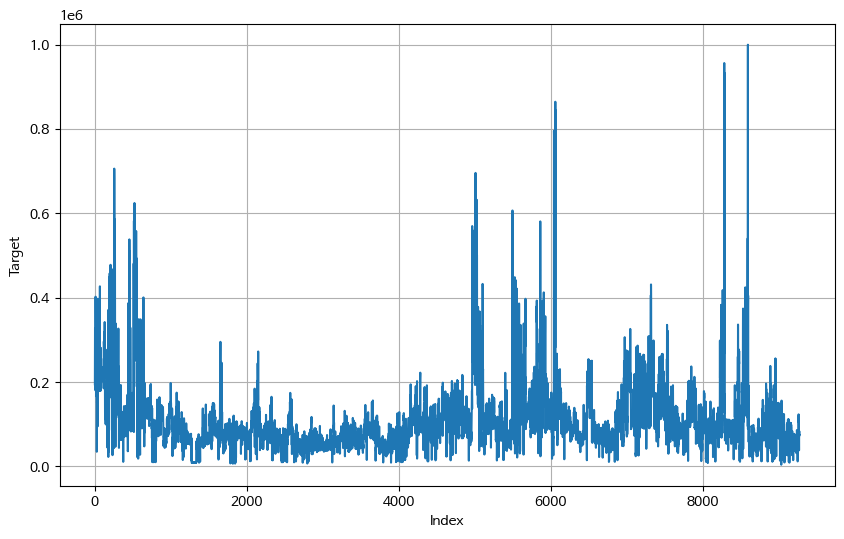

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(xgb_output['target'])
plt.xlabel('Index')
plt.ylabel('Target')
plt.grid(True)
plt.show()

In [58]:
fs_output = pd.read_csv('fs_pred.csv')

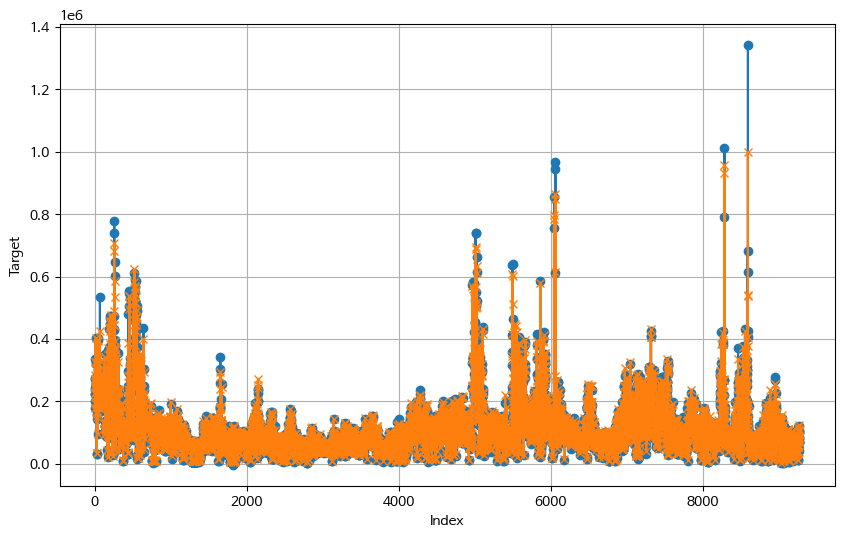

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(fs_output['target'], label='fs', marker='o')
plt.plot(xgb_output['target'], label='xgb', marker='x')
plt.xlabel('Index')
plt.ylabel('Target')
plt.grid(True)
plt.show()

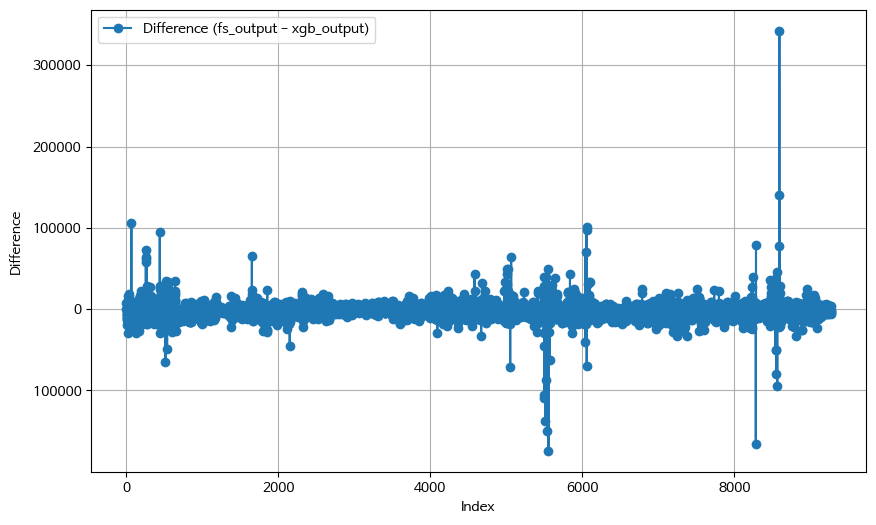

In [62]:
difference = fs_output['target'] - xgb_output['target']

plt.figure(figsize=(10, 6))

plt.plot(difference, label='Difference (fs_output - xgb_output)', marker='o')

plt.xlabel('Index')
plt.ylabel('Difference')

plt.grid(True)

plt.legend()

plt.show()